In [1]:
# importing the dataset with pandas 
import pandas as pd 
df=pd.read_csv("B:\\anime.csv")
df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [2]:
len(df)
len(df.anime_id.unique())

12294

In [3]:
len(df.name.unique())

12292

In [4]:
df['rating'].value_counts()

rating
6.00    141
7.00     99
6.50     90
6.25     84
5.00     76
       ... 
3.47      1
3.71      1
3.87      1
3.91      1
3.14      1
Name: count, Length: 598, dtype: int64

<Axes: >

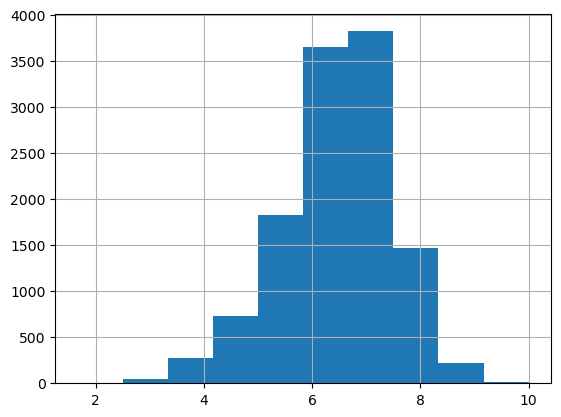

In [5]:
df['rating'].hist()

In [6]:
df.name.value_counts()

name
Shi Wan Ge Leng Xiaohua                           2
Saru Kani Gassen                                  2
Bakabon Osomatsu no Karee wo Tazunete Sansenri    1
Backkom Meogeujan Yeohaeng                        1
Backkom Mission Impossible                        1
                                                 ..
Yoroiden Samurai Troopers Kikoutei Densetsu       1
Yuu☆Yuu☆Hakusho: Mu Mu Hakusho                    1
3-gatsu no Lion meets Bump of Chicken             1
Bannou Bunka Neko-Musume                          1
Yasuji no Pornorama: Yacchimae!!                  1
Name: count, Length: 12292, dtype: int64

In [7]:
features_for_similarity = ['genre', 'rating']
print("Features chosen for similarity computation:", features_for_similarity)

Features chosen for similarity computation: ['genre', 'rating']


In [8]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Identify numerical and categorical columns from the selected features
numerical_features = ['rating']
categorical_features = ['genre']

#pre processing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Create a pipeline that applies the preprocessing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

df_processed = df.dropna(subset=features_for_similarity).copy()

# Apply the pipeline to the selected features
X_processed = pipeline.fit_transform(df_processed[features_for_similarity])

X_processed_dense = X_processed.toarray()

print("Shape of original data:", df.shape)
print("Shape of data after dropping NaNs:", df_processed.shape)
print("Shape of processed features:", X_processed_dense.shape)
print("\nSample of processed features (first 5 rows):\n", X_processed_dense[:5])

Shape of original data: (12294, 7)
Shape of data after dropping NaNs: (12017, 7)
Shape of processed features: (12017, 3230)

Sample of processed features (first 5 rows):
 [[0.92436975 0.         0.         ... 0.         0.         0.        ]
 [0.91116447 0.         0.         ... 0.         0.         0.        ]
 [0.90996399 0.         0.         ... 0.         0.         0.        ]
 [0.90036014 0.         0.         ... 0.         0.         0.        ]
 [0.89915966 0.         0.         ... 0.         0.         0.        ]]


In [10]:
# design a function to recommend anime based on cosine similarity?

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recommend_anime_cosine_similarity(df, processed_features, anime_title, num_recommendations=10):
    try:
        anime_index = df_processed[df_processed['name'] == anime_title].index[0]
        # Find the corresponding index in the processed features array
        # This assumes the order of rows in df_processed matches the rows in processed_features
        processed_index = df_processed.index.get_loc(anime_index)
    except IndexError:
        print(f"Anime '{anime_title}' not found in the dataset or after preprocessing.")
        return pd.DataFrame()


    # Calculate cosine similarity between the target anime and all other anime
    # Need to reshape the target anime's feature vector for similarity calculation
    target_features = processed_features[processed_index].reshape(1, -1)
    similarity_scores = cosine_similarity(target_features, processed_features)

    # Get the similarity scores for the target anime (it's a 1xN array)
    similarity_scores = similarity_scores.flatten()

    # Create a list of tuples (index, score)
    similarity_scores_with_indices = list(enumerate(similarity_scores))

    # Sort the anime by similarity scores in descending order
    # Exclude the anime itself (score of 1.0)
    sorted_similar_anime = sorted(similarity_scores_with_indices, key=lambda x: x[1], reverse=True)[1:] # Skip the first one (itself)

    # Get the top N recommendations
    top_recommendations_indices = [i for i, score in sorted_similar_anime[:num_recommendations]]
    top_recommendations_scores = [score for i, score in sorted_similar_anime[:num_recommendations]]

    # Get the actual anime titles from the original (or processed) DataFrame using the indices
    # Map the indices from processed_features back to the original df_processed indices
    recommended_anime_titles = df_processed.iloc[top_recommendations_indices]['name'].tolist()

    # Create a DataFrame for the recommendations
    recommendations_df = pd.DataFrame({
        'Recommended Anime': recommended_anime_titles,
        'Similarity Score': top_recommendations_scores
    })

    return recommendations_df

# Find a sample anime title from the processed data to test the function
if not df_processed.empty:
    sample_anime_title = df_processed['name'].iloc[0]
    print(f"\nRecommending anime similar to '{sample_anime_title}':")
    recommendations = recommend_anime_cosine_similarity(df_processed, X_processed_dense, sample_anime_title, num_recommendations=5)
    print(recommendations)

    # Example with another title (if available)
    # You might need to check if the title exists in df_processed before calling the function
    another_sample_title = 'Naruto' # Replace with an actual title if known to be in the dataset
    if another_sample_title in df_processed['name'].values:
         print(f"\nRecommending anime similar to '{another_sample_title}':")
         recommendations = recommend_anime_cosine_similarity(df_processed, X_processed_dense, another_sample_title, num_recommendations=5)
         print(recommendations)


Recommending anime similar to 'Kimi no Na wa.':
                         Recommended Anime  Similarity Score
0              Wind: A Breath of Heart OVA          0.972691
1             Wind: A Breath of Heart (TV)          0.968013
2  Taka no Tsume 8: Yoshida-kun no X-Files          0.479979
3              Spoon-hime no Swing Kitchen          0.468030
4                         Mogura no Motoro          0.464905

Recommending anime similar to 'Naruto':
                                   Recommended Anime  Similarity Score
0                                 Naruto: Shippuuden          0.999950
1  Boruto: Naruto the Movie - Naruto ga Hokage ni...          0.999948
2                           Boruto: Naruto the Movie          0.999857
3                                        Naruto x UT          0.999836
4        Naruto: Shippuuden Movie 4 - The Lost Tower          0.999755


In [11]:
# Given a target anime, recommend a list of similar anime based on cosine similarity scores?

target_anime_title = "Naruto"
num_recommendations = 10 

# Ensure the recommend_anime_cosine_similarity function is defined in a previous cell
recommendations = recommend_anime_cosine_similarity(df_processed, X_processed_dense, target_anime_title, num_recommendations=num_recommendations)

if not recommendations.empty:
  print(f"Recommended anime similar to '{target_anime_title}':")
recommendations

Recommended anime similar to 'Naruto':


,Recommended Anime,Similarity Score
0,Naruto: Shippuuden,0.999950
1,Boruto: Naruto the Movie - Naruto ga Hokage ni...,0.999948
2,Boruto: Naruto the Movie,0.999857
3,Naruto x UT,0.999836
4,Naruto: Shippuuden Movie 4 - The Lost Tower,0.999755
5,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0.999699
6,Naruto Shippuuden: Sunny Side Battle,0.999026
7,Naruto Soyokazeden Movie: Naruto to Mashin to ...,0.998395
8,Taka no Tsume 8: Yoshida-kun no X-Files,0.419548
9,Spoon-hime no Swing Kitchen,0.409104


In [12]:
#experiment with different threshold values for similarity scores to adjust the recommendation list size?

import pandas as pd
import numpy as np
def recommend_anime_with_threshold(df, processed_features, anime_title, similarity_threshold=0.5):
    try:
        # Find the index in the df_processed DataFrame
        anime_index_in_processed_df = df_processed[df_processed['name'] == anime_title].index[0]
        # Find the corresponding index in the processed features array
        processed_index = df_processed.index.get_loc(anime_index_in_processed_df)
    except IndexError:
        print(f"Anime '{anime_title}' not found in the dataset or after preprocessing.")
        return pd.DataFrame()

    target_features = processed_features[processed_index].reshape(1, -1)
    similarity_scores = cosine_similarity(target_features, processed_features).flatten()

    # Create a list of tuples (index, score)
    similarity_scores_with_indices = list(enumerate(similarity_scores))

    # Filter anime based on the similarity threshold and exclude the anime itself
    filtered_similar_anime = [(i, score) for i, score in similarity_scores_with_indices
                              if score >= similarity_threshold and i != processed_index]

    # Sort the filtered anime by similarity scores in descending order
    sorted_similar_anime = sorted(filtered_similar_anime, key=lambda x: x[1], reverse=True)

    if not sorted_similar_anime:
        print(f"No anime found with a similarity score above {similarity_threshold} for '{anime_title}'.")
        return pd.DataFrame()

    # Get the indices and scores of the recommended anime
    recommended_anime_indices_in_processed_df = [df_processed.index[i] for i, score in sorted_similar_anime]
    recommended_anime_scores = [score for i, score in sorted_similar_anime]

    # Get the actual anime titles from the original (or processed) DataFrame using the indices
    recommended_anime_titles = df_processed.loc[recommended_anime_indices_in_processed_df]['name'].tolist()

    # Create a DataFrame for the recommendations
    recommendations_df = pd.DataFrame({
        'Recommended Anime': recommended_anime_titles,
        'Similarity Score': recommended_anime_scores
    })

    return recommendations_df

# --- Experimenting with different threshold values ---

target_anime_title_exp = "Naruto" #@param {type:"string"}
threshold_values = [0.3, 0.5, 0.7, 0.9] # Different threshold values to experiment with

print(f"\nExperimenting with different similarity thresholds for '{target_anime_title_exp}':")

for threshold in threshold_values:
    print(f"\n--- Threshold: {threshold} ---")
    recommendations_threshold = recommend_anime_with_threshold(df_processed, X_processed_dense, target_anime_title_exp, similarity_threshold=threshold)

    if not recommendations_threshold.empty:
        print(f"Found {len(recommendations_threshold)} recommendations:")
        print(recommendations_threshold)
    else:
        print("No recommendations found above this threshold.")


Experimenting with different similarity thresholds for 'Naruto':

--- Threshold: 0.3 ---
Found 6082 recommendations:
                                      Recommended Anime  Similarity Score
0                                    Naruto: Shippuuden          0.999950
1     Boruto: Naruto the Movie - Naruto ga Hokage ni...          0.999948
2                              Boruto: Naruto the Movie          0.999857
3                                           Naruto x UT          0.999836
4           Naruto: Shippuuden Movie 4 - The Lost Tower          0.999755
...                                                 ...               ...
6077                             Hitoriga The Animation          0.300374
6078  Hitozuma Cosplay Kissa 2: Hitozuma LoveLove - ...          0.300374
6079                            Houkago: Nureta Seifuku          0.300374
6080                                Otome Chibaku Yuugi          0.300374
6081                                            Vampire          0.3

In [29]:
#split the dataset into training and testing sets 

from sklearn.model_selection import train_test_split

y = df_processed['rating'] # Using the rating as the target variable for the split example

# Split the processed features (X_processed_dense) and the target (y)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed_dense, y, test_size=0.2, random_state=42
)

print("\nDataset split into training and testing sets:")
print("Shape of training features (X_train):", X_train.shape)
print("Shape of testing features (X_test):", X_test.shape)
print("Shape of training target (y_train):", y_train.shape)
print("Shape of testing target (y_test):", y_test.shape)


Dataset split into training and testing sets:
Shape of training features (X_train): (9613, 3230)
Shape of testing features (X_test): (2404, 3230)
Shape of training target (y_train): (9613,)
Shape of testing target (y_test): (2404,)


In [30]:
# Evaluate the recommendation system using appropriate metrics such as precision, recall, and F1-score in a short 6-10 lines of code

from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
rating_threshold = 7.0 # Example threshold for relevance
y_true_binary = (y_test >= rating_threshold).astype(int) # True relevance based on test ratings
np.random.seed(42) # for reproducibility
y_pred_binary = np.random.randint(0, 2, size=len(y_test))

# Calculate metrics
precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.3246
Recall: 0.4818
F1-score: 0.3878


In [ ]:
Interview Questions:
1. Can you explain the difference between user-based and item-based collaborative filtering?
A. Based on their ratings, the user-based collaborative filtering finds similar users and recommends items liked by those similar users.

2. What is collaborative filtering, and how does it work?
A. It is a recommendation technique that predicts a user's interests by analyzing patterns of ratings or interactions from many users.
   It works by finding similar users or items and suggesting what similar users liked (user-based) or items similar to what the user liked (item-based).